# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
#pip install -qU ragas==0.2.10

In [2]:
#pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/tkoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tkoh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key: ········


We'll also want to set a project name to make things easier for ourselves.

In [6]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [7]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key: ········


## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [8]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [9]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31493    0 31493    0     0   584k      0 --:--:-- --:--:-- --:--:--  591k


In [10]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70519    0 70519    0     0  1337k      0 --:--:-- --:--:-- --:--:-- 1350k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [11]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()



### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [12]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())



Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [13]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [14]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [15]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/18 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 10, relationships: 35)

We can save and load our knowledge graphs as follows.

In [16]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 10, relationships: 35)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [17]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [18]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

SingleHop - One retrieval step. It does not require looking at more than one piece of content. It generates straightforward questions that can be answered using information from a single specific section of the documents.

MultiHopAbstract - Answers questions by retrieving and reasoning across multiple steps. Multi-hop abstract evaluation assesses faithfulness, correctness, and logical consistency of the final output based on chained evidence. It ensures that multi-step reasoning is handled, but does not check each individual step separately.

MultiHopSpecific - Unlike MultiHopAbstract, MultiHopSpecific evaluates each reasoning step individually for accuracy, relevance, and faithfulness. It ensures that every hop in the retrieval and reasoning chain is correct, because a failure at any step can cause the final answer to be wrong.

in simple terms... 

SingleHop = only one retrieval.

MultiHopAbstract = multiple retrievals + focus on final answer only.

MultiHopSpecific = multiple retrievals + check each step individually.


Finally, we can use our `TestSetGenerator` to generate our testset!

In [ ]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

In [19]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What role does OpenAI play in the development ...,[The ethics of this space remain diabolically ...,"According to the provided context, OpenAI was ...",single_hop_specifc_query_synthesizer
1,What are LLMs?,[Simon Willison’s Weblog Subscribe Stuff we fi...,Large Language Models (LLMs) are the latest de...,single_hop_specifc_query_synthesizer
2,Is it ok to train models on people's content w...,[the document includes some of the clearest ex...,The context discusses ethical questions surrou...,single_hop_specifc_query_synthesizer
3,What were the key developments related to larg...,[Things we learned about LLMs in 2024 31st Dec...,"In 2024, significant advancements in large lan...",single_hop_specifc_query_synthesizer
4,Is GPT-4 considered a powerful model for AI ta...,[punch massively above their weight. I run Lla...,The provided context does not mention GPT-4 sp...,single_hop_specifc_query_synthesizer
5,How do the recent advancements in multimodal A...,[<1-hop>\n\nThings we learned about LLMs in 20...,The 2024 review highlights that multimodal vis...,multi_hop_abstract_query_synthesizer
6,Considering the significant impact of AI techn...,[<1-hop>\n\nthe document includes some of the ...,The context emphasizes that while LLMs have th...,multi_hop_abstract_query_synthesizer
7,How does the environmental impact of AI relate...,[<1-hop>\n\npunch massively above their weight...,Recent developments in large language models (...,multi_hop_abstract_query_synthesizer
8,How do recent developments in Large Language M...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,"Recent developments in 2024, including the exp...",multi_hop_specific_query_synthesizer
9,how ChatGPT and ChatGPT use synthetic data and...,[<1-hop>\n\nways we should not be using genera...,ChatGPT is a large language model that relies ...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [20]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/18 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What is OpenAI's role in the development of la...,[The ethics of this space remain diabolically ...,"According to the provided context, OpenAI was ...",single_hop_specifc_query_synthesizer
1,What are the key characteristics and challenge...,[Simon Willison’s Weblog Subscribe Stuff we fi...,"According to the context, Large Language Model...",single_hop_specifc_query_synthesizer
2,How does the document describe the role and si...,[the document includes some of the clearest ex...,The document mentions OpenAI as a prominent en...,single_hop_specifc_query_synthesizer
3,What is Claude and how does it compare to othe...,[Things we learned about LLMs in 2024 31st Dec...,Claude is an LLM developed by Anthropic that l...,single_hop_specifc_query_synthesizer
4,"So, like, if LLMs are really smart but also re...",[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,"According to Simon Willison’s weblog, 2023 was...",multi_hop_abstract_query_synthesizer
5,how AI ethics and impact on life and work rela...,[<1-hop>\n\nThe ethics of this space remain di...,"The ethics of AI and LLMs are complex, involvi...",multi_hop_abstract_query_synthesizer
6,how does the on-device AI and open source proj...,[<1-hop>\n\nthe document includes some of the ...,the context discusses the complex legal and et...,multi_hop_abstract_query_synthesizer
7,How do the development and impact of inference...,[<1-hop>\n\nacknowledge that. If you tell me t...,The rise of inference-scaling reasoning models...,multi_hop_abstract_query_synthesizer
8,How do the themes of Meta's advancements in la...,[<1-hop>\n\nthe document includes some of the ...,The context highlights Meta's significant prog...,multi_hop_specific_query_synthesizer
9,Considering the advancements in Large Language...,[<1-hop>\n\nThings we learned about LLMs in 20...,"In 2024, the field of Large Language Models sa...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [23]:
from langsmith import Client

client = Client()

dataset_name = "Test State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [24]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [25]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [26]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [27]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [28]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

/mnt/c/Users/T/Documents/GitHub/AIE6/07_Synthetic_Data_Generation_and_LangSmith/venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:758: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is empty, alternative syntax for `is_empty: \&quot;field_name\&quot;`",
/mnt/c/Users/T/Documents/GitHub/AIE6/07_Synthetic_Data_Generation_and_LangSmith/venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:762: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is null, alternative syntax for `is_null: \&quot;field_name\&quot;`",


In [29]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [30]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [31]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [32]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [33]:
rag_chain.invoke({"question" : "What are Agents?"})

'Based on the provided context, "agents" is an infuriatingly vague term without a single, clear, and widely understood meaning. Generally, the term seems to be converging on AI systems that can go away and act on your behalf, but there are many different interpretations. Two main categories include: \n\n1. AI agents modeled as entities that act on your behalf, similar to a travel agent.\n2. Large language models (LLMs) given access to tools which they use in a loop to solve problems.\n\nHowever, despite much discussion and excitement about AI agents, there are few real examples running in production, and the concept still feels perpetually "coming soon." A key challenge for agents is overcoming LLMs’ gullibility, meaning their tendency to believe anything they are told, which limits their reliability as decision-makers or assistants. Some believe fully solving this issue depends on achieving artificial general intelligence (AGI).\n\nIn summary, "agents" refer to AI systems intended to 

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [34]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [35]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: Measures if things are factually accurate w/ reference answers
- `labeled_helpfulness_evaluator`: this evaluates if its helpful to the user taking into account the correct answer
- `dope_or_nope_evaluator`: measures the "dope" factor. This is custom evaluator we create to measure that specifically. We could also create other criteria here like keeping it simple etc. Dopeness is just subjective and engaging as a test

## LangSmith Evaluation

In [36]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'unique-canvas-60' at:
https://smith.langchain.com/o/4d1f1958-8176-44c8-9ea2-c2bad5b7b373/datasets/fedb24f0-235b-4807-9eb4-2bbf3622b966/compare?selectedSessions=8440e108-b690-4c95-86dd-28b0df35e126




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Claude 3 compare to other LLMs like C...,Based on the provided context:\n\n- Claude 3 s...,None,"Based on the context, Claude 3 is mentioned al...",1,1,0,9.731937,0e64913e-97f9-4956-9f8b-783da9aae845,6d5b276b-428f-4234-9f8a-ea91ff8461c3
1,How do the developments in Claude 3 and Claude...,The developments in Claude 3 and Claude 3.5 in...,None,"In 2024, the Claude 3 series from Anthropic, i...",1,1,0,4.426515,deb74548-0df7-4eb9-b16e-996d46a3ca55,025046b3-f0bf-4f99-acde-8bf864967ab9
2,Considering the advancements in Large Language...,I don't know.,None,"In 2024, the field of Large Language Models sa...",0,0,0,0.576531,ce52e2e9-f946-4e7e-a914-f385d03e3d41,7b981abf-e906-4c6a-b38c-dc250e88d4f0
3,How do the themes of Meta's advancements in la...,"Meta's advancements in large language models, ...",None,The context highlights Meta's significant prog...,1,1,0,10.379972,64dea286-b665-4a68-a176-c63378c41861,ba76424d-c81b-4efd-b37a-15773046a8cc
4,How do the development and impact of inference...,"Based on the provided context, inference-scali...",None,The rise of inference-scaling reasoning models...,0,0,0,5.367160,18cbf01a-34d4-4a7a-a7b8-900a17c9bd99,ae2941e8-44dc-4fa1-b3ab-feb6c3600c95
5,how does the on-device AI and open source proj...,I don't know.,None,the context discusses the complex legal and et...,0,0,0,0.841467,afd3afef-ced3-4317-9abd-b6a4d487ba5e,198eeca8-f69b-455f-8f33-0c2d3932174c
6,how AI ethics and impact on life and work rela...,"Based on the provided context, AI ethics and i...",None,"The ethics of AI and LLMs are complex, involvi...",1,1,0,3.434112,6d8ca790-5b56-409a-9b9d-ee0a06334cfa,5954eb70-51aa-457b-801b-a1cf13ba4901
7,"So, like, if LLMs are really smart but also re...","Based on the context, LLMs demonstrate a mix o...",None,"According to Simon Willison’s weblog, 2023 was...",1,1,0,3.694180,6cf83788-0a93-4ed8-94a8-ef6cc524f6b9,ed80c9c9-8d4a-4da3-a140-cdbfd46da5e3
8,What is Claude and how does it compare to othe...,Claude is a series of Large Language Models (L...,None,Claude is an LLM developed by Anthropic that l...,1,0,0,4.975485,8b5bdc9c-af90-4fb8-97cc-b5fbb2ef506f,62eef035-c81b-41b1-9a86-096a3ddfbf53
9,How does the document describe the role and si...,The document describes OpenAI as a pioneering ...,None,The document mentions OpenAI as a prominent en...,1,1,0,5.923799,88eedd67-5958-4f05-aeec-af746120a9f9,03a6a45b-79a0-4baa-8b5d-a69633d1dd56


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [37]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [38]:
rag_documents = docs

In [39]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

Our goal is always to have optimal chunk size
A balance between including enough context for accurate answers and maintaining system speed and efficiency
If we don't include enough context some of the meaning can be lost


In [40]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

Upgrading to text-embedding-3-large made our retrievals smarter and more precise, because it captures more meaning and finer distinctions in the text.



In [41]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [42]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [43]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [44]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Alright, here’s the scoop on "agents" from the vibe of the context you gave me:\n\n"Agents" is one of those buzzwords in AI that\'s still kinda fuzzy, like trying to catch smoke with your bare hands. People toss the term around a lot, but there’s no universal definition that sticks. Some folks mean AI systems that act on your behalf—like a travel agent booking your trip, but digital. Others are talking about large language models (LLMs) with access to tools they can run in loops to solve problems.\n\nThe real kicker? This whole agent thing feels like it’s “coming soon” but never quite lands. Why? Gullibility. These AI agents tend to believe whatever they’re told, sometimes spitting out fake stuff like that wild "Encanto 2" fake movie plot Google accidentally recommended. Until AI can get smarter about distinguishing fact from fiction, true autonomous agents remain a dream.\n\nSo, TL;DR: Agents = AI systems that act for you, but they\'re still more hype than reality \'cause they strugg

Finally, we can evaluate the new chain on the same test set!

In [45]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'spotless-detail-79' at:
https://smith.langchain.com/o/4d1f1958-8176-44c8-9ea2-c2bad5b7b373/datasets/fedb24f0-235b-4807-9eb4-2bbf3622b966/compare?selectedSessions=712ec9c2-0eb1-4223-8712-3c47a427b1e0




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Claude 3 compare to other LLMs like C...,"Alright, here’s the lowdown on Claude 3 and it...",None,"Based on the context, Claude 3 is mentioned al...",1,0,1,4.224248,0e64913e-97f9-4956-9f8b-783da9aae845,4490c105-edda-4a84-aad2-30b3686ba88a
1,How do the developments in Claude 3 and Claude...,"Alright, let's break it down smooth like jazz....",None,"In 2024, the Claude 3 series from Anthropic, i...",1,1,1,6.863579,deb74548-0df7-4eb9-b16e-996d46a3ca55,80b05127-e9a3-4830-9f4f-ebb3ce01c38b
2,Considering the advancements in Large Language...,"Yo, based on the context you dropped, I gotta ...",None,"In 2024, the field of Large Language Models sa...",0,0,1,3.268683,ce52e2e9-f946-4e7e-a914-f385d03e3d41,28d2168c-d73e-4255-92a8-091e1205f9d9
3,How do the themes of Meta's advancements in la...,"Alright, let me break it down cool style: Meta...",None,The context highlights Meta's significant prog...,1,1,1,3.610363,64dea286-b665-4a68-a176-c63378c41861,97865c39-18e0-4fad-ad6f-8dc8d0f13903
4,How do the development and impact of inference...,"Alright, here’s the skinny — inference-scaling...",None,The rise of inference-scaling reasoning models...,1,1,1,5.149070,18cbf01a-34d4-4a7a-a7b8-900a17c9bd99,81fbed96-613c-491e-8707-14a14e12081e
5,how does the on-device AI and open source proj...,"Alright, here’s the deal. The context doesn’t ...",None,the context discusses the complex legal and et...,0,0,1,4.714564,afd3afef-ced3-4317-9abd-b6a4d487ba5e,c42e3659-24a1-4f2f-aef7-908d9588e1fc
6,how AI ethics and impact on life and work rela...,"Alright, here’s the lowdown, straight from the...",None,"The ethics of AI and LLMs are complex, involvi...",1,1,1,4.585979,6d8ca790-5b56-409a-9b9d-ee0a06334cfa,65c61c57-43d7-4284-8ce3-fa3c1b9693d9
7,"So, like, if LLMs are really smart but also re...","Aight, here’s the lowdown, straight fire style...",None,"According to Simon Willison’s weblog, 2023 was...",1,1,1,6.143094,6cf83788-0a93-4ed8-94a8-ef6cc524f6b9,1ab8be3b-644c-4809-b293-1834fcd947fc
8,What is Claude and how does it compare to othe...,"Alright, here’s the lowdown on Claude in 2024,...",None,Claude is an LLM developed by Anthropic that l...,0,0,1,3.254092,8b5bdc9c-af90-4fb8-97cc-b5fbb2ef506f,f70325d0-5b81-420f-b008-a330f4223567
9,How does the document describe the role and si...,"Alright, here’s the lowdown on OpenAI’s role a...",None,The document mentions OpenAI as a prominent en...,1,1,1,3.662986,88eedd67-5958-4f05-aeec-af746120a9f9,82135ed9-92a9-48df-a37b-db55ef05bc8f


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

We added some augmentations in our prompt in the second test (spotless-detail-79) as an improvement to dopeness as well as improve the retriever model to text-embedding-3-large and use larger chunks 500>1000 and overlap stays at 50 to get more semantic understanding. This improves our stats in correctness and dopeness but helpfulness became lower. 

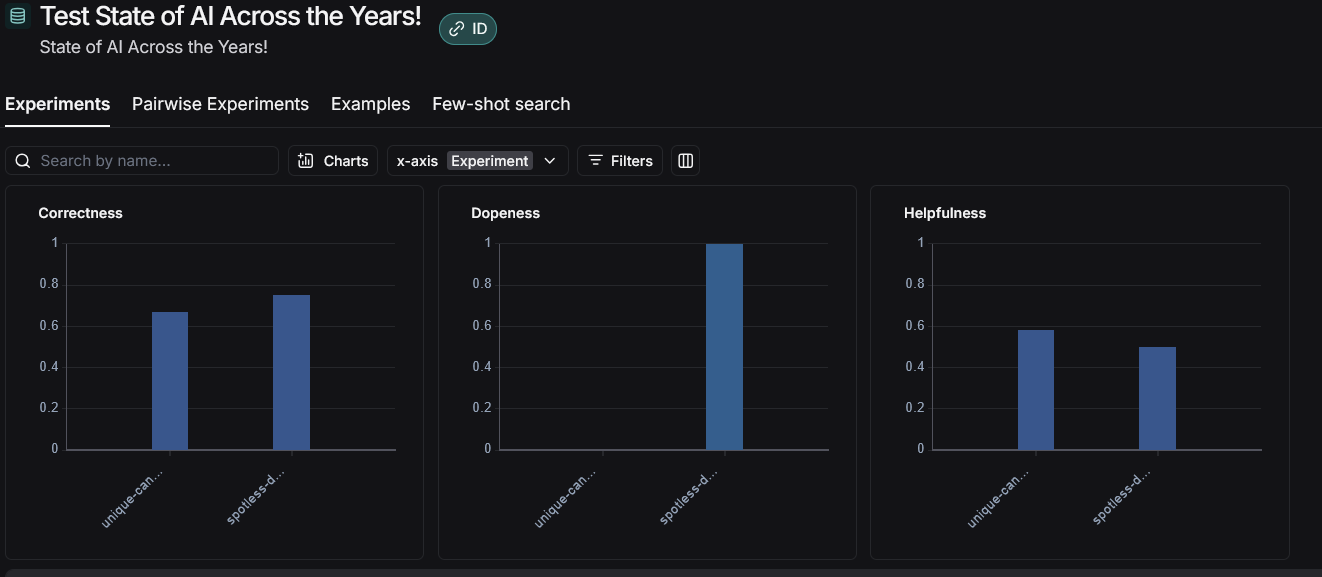
